In [1]:
# -*- coding: utf-8 -*-
import requests
import time
import os
import glob
import math
import ssl
import pandas as pd
import geopandas as gpd
from requests.adapters import HTTPAdapter
import json
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
from snownlp import SnowNLP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
font_path="C:/Windows/Fonts/simhei.ttf"
plt.rcParams['font.sans-serif'] = ['SimHei']   # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

#### 统计不同城市不同类型得分的表格

In [4]:
# === 读取数据 ===
df = pd.read_csv('./df_all.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_32044\1440234774.py:2: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./df_all.csv', encoding='utf-8-sig')


In [6]:
df = df.drop_duplicates(subset="commentId", keep="first")

In [ ]:
# 这个是新版本
# === 聚合统计 ===
type_stats = df.groupby(['city', 'poi_type']).agg(
    评论总数=('score', 'count'),
    正面评论比例=('score', lambda x: (x >= 4).mean()),
    中性评论比例=('score', lambda x: (x == 3).mean()),
    负面评论比例=('score', lambda x: (x <= 2).mean()),
    平均分数=('score', 'mean'),
    poi数量=('poi_id', 'nunique')
).reset_index()

# === 添加全局统计（所有类型汇总） ===
global_stats = df.groupby('city').agg(
    评论总数=('score', 'count'),
    正面评论比例=('score', lambda x: (x >= 4).mean()),
    中性评论比例=('score', lambda x: (x == 3).mean()),
    负面评论比例=('score', lambda x: (x <= 2).mean()),
    平均分数=('score', 'mean'),
    poi数量=('poi_id', 'nunique')
).reset_index()
global_stats['poi_type'] = '所有类型'

# 合并
agg_df = pd.concat([type_stats, global_stats], ignore_index=True)

# === 保存结果 ===
output_file = '各城市_类型评分统计_单文件版.csv'
agg_df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"✅ 聚合结果已保存为：{output_file}")


✅ 聚合结果已保存为：各城市_类型评分统计_单文件版.csv


In [8]:
agg_df

,city,poi_type,评论总数,正面评论比例,中性评论比例,负面评论比例,平均分数,poi数量
0,上海,体验考察型,98,0.816327,0.102041,0.081633,4.244898,10
1,上海,励志拓展型,664,0.939759,0.040663,0.019578,4.623494,38
2,上海,文化康乐型,3973,0.796124,0.124339,0.079537,4.245910,3
3,上海,知识科普型,107093,0.922208,0.041702,0.036090,4.628967,297
4,上海,自然观赏型,88,0.920455,0.034091,0.045455,4.500000,3
...,...,...,...,...,...,...,...,...
190,重庆,所有类型,12223,0.905261,0.048024,0.046715,4.576536,176
191,陕西,所有类型,65705,0.853862,0.051320,0.094818,4.416194,320
192,青海,所有类型,9012,0.919330,0.042832,0.037838,4.636041,80
193,香港,所有类型,4965,0.948640,0.034240,0.017120,4.726083,53


In [9]:
all_types_df = agg_df[agg_df['poi_type'] == '所有类型'].copy()
	# 按正面评论比例降序排名（相同比例取最小排名）
all_types_df['排名'] = all_types_df['正面评论比例'].rank(
    ascending=False,  # 降序
    method='min'      # 相同值取最小排名
).astype(int)

# 按排名升序排序（排名1的显示在最前面）
all_types_df = all_types_df.sort_values('排名')

In [11]:
# 统计每个 poi_type 的出现次数
poi_type_counts = agg_df['poi_type'].value_counts()

# 输出结果
print(poi_type_counts)

poi_type
文化康乐型    34
知识科普型    34
自然观赏型    34
所有类型     34
励志拓展型    32
体验考察型    27
Name: count, dtype: int64


##### 知识科普型的分布

In [12]:
types_1_df = agg_df[agg_df['poi_type'] == '知识科普型'].copy()
print(types_1_df.isnull().sum())
print(types_1_df.shape)

city        0
poi_type    0
评论总数        0
正面评论比例      0
中性评论比例      0
负面评论比例      0
平均分数        0
poi数量       0
dtype: int64
(34, 8)


##### 箱型图的绘制

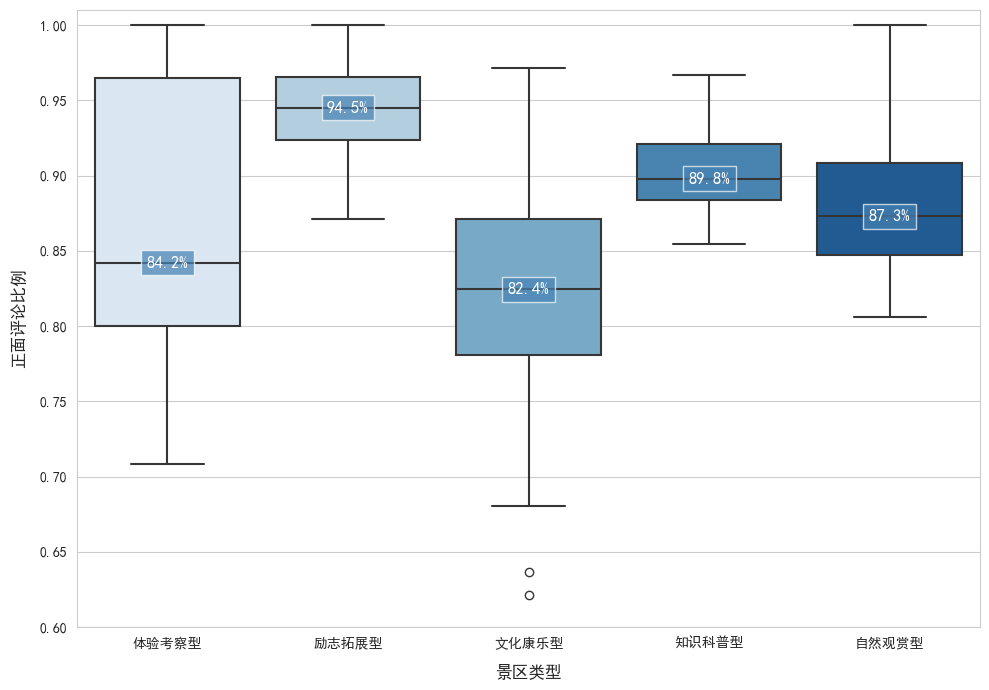

In [14]:
# 设置全局风格
sns.set_style("whitegrid")  # 正确的Seaborn样式名称
sns.set_palette("Blues")
	# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 
 
# 绘制箱型图
plt.figure(figsize=(10, 7))
ax = sns.boxplot(
    data=agg_df[agg_df['poi_type'] != '所有类型'],
    x='poi_type',
    y='正面评论比例',
    hue='poi_type',
    palette='Blues',  # 深蓝色渐变
    linewidth=1.5,      # 加粗箱线边框
    fliersize=6         # 调整异常点大小
)

ymin, ymax = 0.6, agg_df['正面评论比例'].max() + 0.01
plt.ylim(ymin, ymax)
# 优化标题和标签
# plt.title('不同类型景区的正面评论比例分布', fontsize=16, pad=20, weight='bold')
plt.ylabel('正面评论比例', fontsize=12, labelpad=10)
plt.xlabel('景区类型', fontsize=12, labelpad=10)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
 
# 移除图例（因x轴已标注类型）
# ax.legend_.remove()
 
# 添加数据标签（可选：显示中位数）
medians = agg_df[agg_df['poi_type'] != '所有类型'].groupby('poi_type')['正面评论比例'].median()
for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.1%}', ha='center', va='center', fontsize=12, color='white', bbox=dict(facecolor='steelblue', alpha=0.7))
 
# 调整布局并保存
plt.tight_layout()
plt.savefig("箱型图_正面评论比例_优化版.png", dpi=300, bbox_inches='tight')
plt.show()

##### 卡方检验

In [15]:
import pandas as pd
from scipy import stats

# 筛选数据
data = agg_df[agg_df['poi_type'] != '所有类型']

# 指定要比较的数值变量
target_col = '正面评论比例'  # 换成你需要比较的字段名

# 分组提取数据
groups = [group[target_col].dropna().values for name, group in data.groupby('poi_type')]

# 方差分析（ANOVA）
f_stat, p_val = stats.f_oneway(*groups)

print(f"F统计量: {f_stat:.3f}, p值: {p_val:.5f}")
if p_val < 0.05:
    print("→ 不同 poi_type 之间的差异显著。")
else:
    print("→ 不同 poi_type 之间的差异不显著。")

F统计量: 13.980, p值: 0.00000
→ 不同 poi_type 之间的差异显著。


In [18]:
# 对每种 poi_type 找出正面评论比例最高的前10个城市
top10_by_type = (
    data.sort_values(['poi_type', '正面评论比例'], ascending=[True, False])
        .groupby('poi_type')
        .head(15)
        .reset_index(drop=True)
)

# 可选：查看结果
print(top10_by_type[['poi_type', 'city', '评论总数','正面评论比例','poi数量']])

   poi_type city   评论总数    正面评论比例  poi数量
0     体验考察型   宁夏     25  1.000000      3
1     体验考察型   贵州      2  1.000000      1
2     体验考察型   辽宁      2  1.000000      1
3     体验考察型   陕西      4  1.000000      2
4     体验考察型   香港      2  1.000000      1
..      ...  ...    ...       ...    ...
70    自然观赏型   四川  15736  0.896098     44
71    自然观赏型   浙江   4972  0.895213     24
72    自然观赏型  黑龙江   5581  0.894105     29
73    自然观赏型   江苏   8549  0.887940     25
74    自然观赏型   北京   4508  0.886868     11

[75 rows x 5 columns]


In [20]:
top10_by_type.to_csv("./data/每个类型的前15名城市.csv", index=False, encoding='utf-8-sig')

#### 可视化不同城市之间存在差异的图

In [22]:
city_code =  pd.read_csv('city_id.csv', encoding='utf-8-sig')
city_sp = gpd.read_file('中国_省.geojson')

In [27]:
# 这个暂时不要用
# 另一种方法：分别对每个指标进行pivot，然后合并
def create_wide_format(df, value_col):
    """为指定指标创建宽格式"""
    wide = df.pivot(index='city', columns='poi_type', values=value_col)
    wide.columns = [f'{value_col}_{col}' for col in wide.columns]
    return wide.reset_index()

# 分别转换三个指标
rating_wide = create_wide_format(agg_df, '平均分数')
rate_wide = create_wide_format(agg_df, '正面评论比例')
count_wide = create_wide_format(agg_df, '评论总数')

# 合并三个宽格式数据
wide_df = rating_wide.merge(rate_wide, on='city').merge(count_wide, on='city')
# 差一个如果na就给0没有但是还是要显示
print("合并后的宽格式数据:")
print(wide_df.head())

合并后的宽格式数据:
  city  平均分数_体验考察型  平均分数_励志拓展型  平均分数_所有类型  平均分数_文化康乐型  平均分数_知识科普型  平均分数_自然观赏型  \
0   上海    4.244898    4.623494   4.614899    4.245910    4.628967    4.500000   
1   云南         NaN    4.685315   4.515855    3.943193    4.626887    4.403486   
2  内蒙古    4.979452    4.833333   4.539743    3.909091    4.712964    4.333249   
3   北京    4.655172    4.669394   4.516117    4.270270    4.514968    4.511979   
4   台湾         NaN    4.800000   4.742885    4.733108    4.751118    4.707513   

   正面评论比例_体验考察型  正面评论比例_励志拓展型  正面评论比例_所有类型  正面评论比例_文化康乐型  正面评论比例_知识科普型  \
0      0.816327      0.939759     0.917742      0.796124      0.922208   
1           NaN      0.951049     0.880993      0.680705      0.915156   
2      0.993151      1.000000     0.883646      0.636364      0.931190   
3      0.931034      0.972177     0.883084      0.810811      0.881808   
4           NaN      1.000000     0.959566      0.971284      0.961066   

   正面评论比例_自然观赏型  评论总数_体验考察型  评论总数_励志拓展型  评论总数_所有类型  评论总数_

In [29]:
# 2. 定义宽表转换函数
def create_wide_format(df, value_col):
    """为指定指标创建宽格式"""
    wide = df.pivot(index='city', columns='poi_type', values=value_col)
    wide.columns = [f'{value_col}_{col}' for col in wide.columns]
    return wide.reset_index()

# 分别转化为宽表
rating_wide = create_wide_format(agg_df, '平均分数')
positive_wide = create_wide_format(agg_df, '正面评论比例')
count_wide = create_wide_format(agg_df, '评论总数')
poi_wide = create_wide_format(agg_df, 'poi数量')

# 合并所有宽表并填充缺失值
wide_df = (
    rating_wide
    .merge(positive_wide, on='city', how='outer')
    .merge(count_wide, on='city', how='outer')
    .merge(poi_wide, on='city', how='outer')
    .fillna(0)
)

print("合并后的宽格式数据:")
print(wide_df.head())

合并后的宽格式数据:
  city  平均分数_体验考察型  平均分数_励志拓展型  平均分数_所有类型  平均分数_文化康乐型  平均分数_知识科普型  平均分数_自然观赏型  \
0   上海    4.244898    4.623494   4.614899    4.245910    4.628967    4.500000   
1   云南    0.000000    4.685315   4.515855    3.943193    4.626887    4.403486   
2  内蒙古    4.979452    4.833333   4.539743    3.909091    4.712964    4.333249   
3   北京    4.655172    4.669394   4.516117    4.270270    4.514968    4.511979   
4   台湾    0.000000    4.800000   4.742885    4.733108    4.751118    4.707513   

   正面评论比例_体验考察型  正面评论比例_励志拓展型  正面评论比例_所有类型  ...  评论总数_所有类型  评论总数_文化康乐型  \
0      0.816327      0.939759     0.917742  ...   111916.0      3973.0   
1      0.000000      0.951049     0.880993  ...    38191.0      1021.0   
2      0.993151      1.000000     0.883646  ...    16871.0        22.0   
3      0.931034      0.972177     0.883084  ...    58136.0        74.0   
4      0.000000      1.000000     0.959566  ...     7098.0       592.0   

   评论总数_知识科普型  评论总数_自然观赏型  poi数量_体验考察型  poi数量_励志拓展型  poi数

In [30]:
wide_df.to_csv('城市景区概况.csv', index=False, encoding='utf-8-sig')
print("已成功导出为 城市景区概况.csv")

已成功导出为 城市景区概况.csv


In [31]:
# 合并好评率数据
city_code_with_rating = pd.merge(city_code, wide_df, 
                                left_on='city_name',  # city_code中的城市名列
                                right_on='city',      # wide_df中的城市名列
                                how='left')
print("\ncity_sp列名:", city_sp.columns.tolist())
print("city_code列名:", city_code_with_rating.columns.tolist())


city_sp列名: ['name', 'gb', 'geometry']
city_code列名: ['city_name', 'city_ename', 'city_id', 'city_code', 'gb', 'city', '平均分数_体验考察型', '平均分数_励志拓展型', '平均分数_所有类型', '平均分数_文化康乐型', '平均分数_知识科普型', '平均分数_自然观赏型', '正面评论比例_体验考察型', '正面评论比例_励志拓展型', '正面评论比例_所有类型', '正面评论比例_文化康乐型', '正面评论比例_知识科普型', '正面评论比例_自然观赏型', '评论总数_体验考察型', '评论总数_励志拓展型', '评论总数_所有类型', '评论总数_文化康乐型', '评论总数_知识科普型', '评论总数_自然观赏型', 'poi数量_体验考察型', 'poi数量_励志拓展型', 'poi数量_所有类型', 'poi数量_文化康乐型', 'poi数量_知识科普型', 'poi数量_自然观赏型']


In [32]:
city_sp['gb'] = city_sp['gb'].astype(str)
city_code_with_rating['gb'] = city_code_with_rating['gb'].astype(str)
merged_data = city_sp.merge(city_code_with_rating, 
                           left_on='gb', 
                           right_on='gb', 
                           how='left')

print("合并完成！")
print(f"总省份数: {len(merged_data)}")

合并完成！
总省份数: 42


统一色域范围: 0.650 ~ 1.000


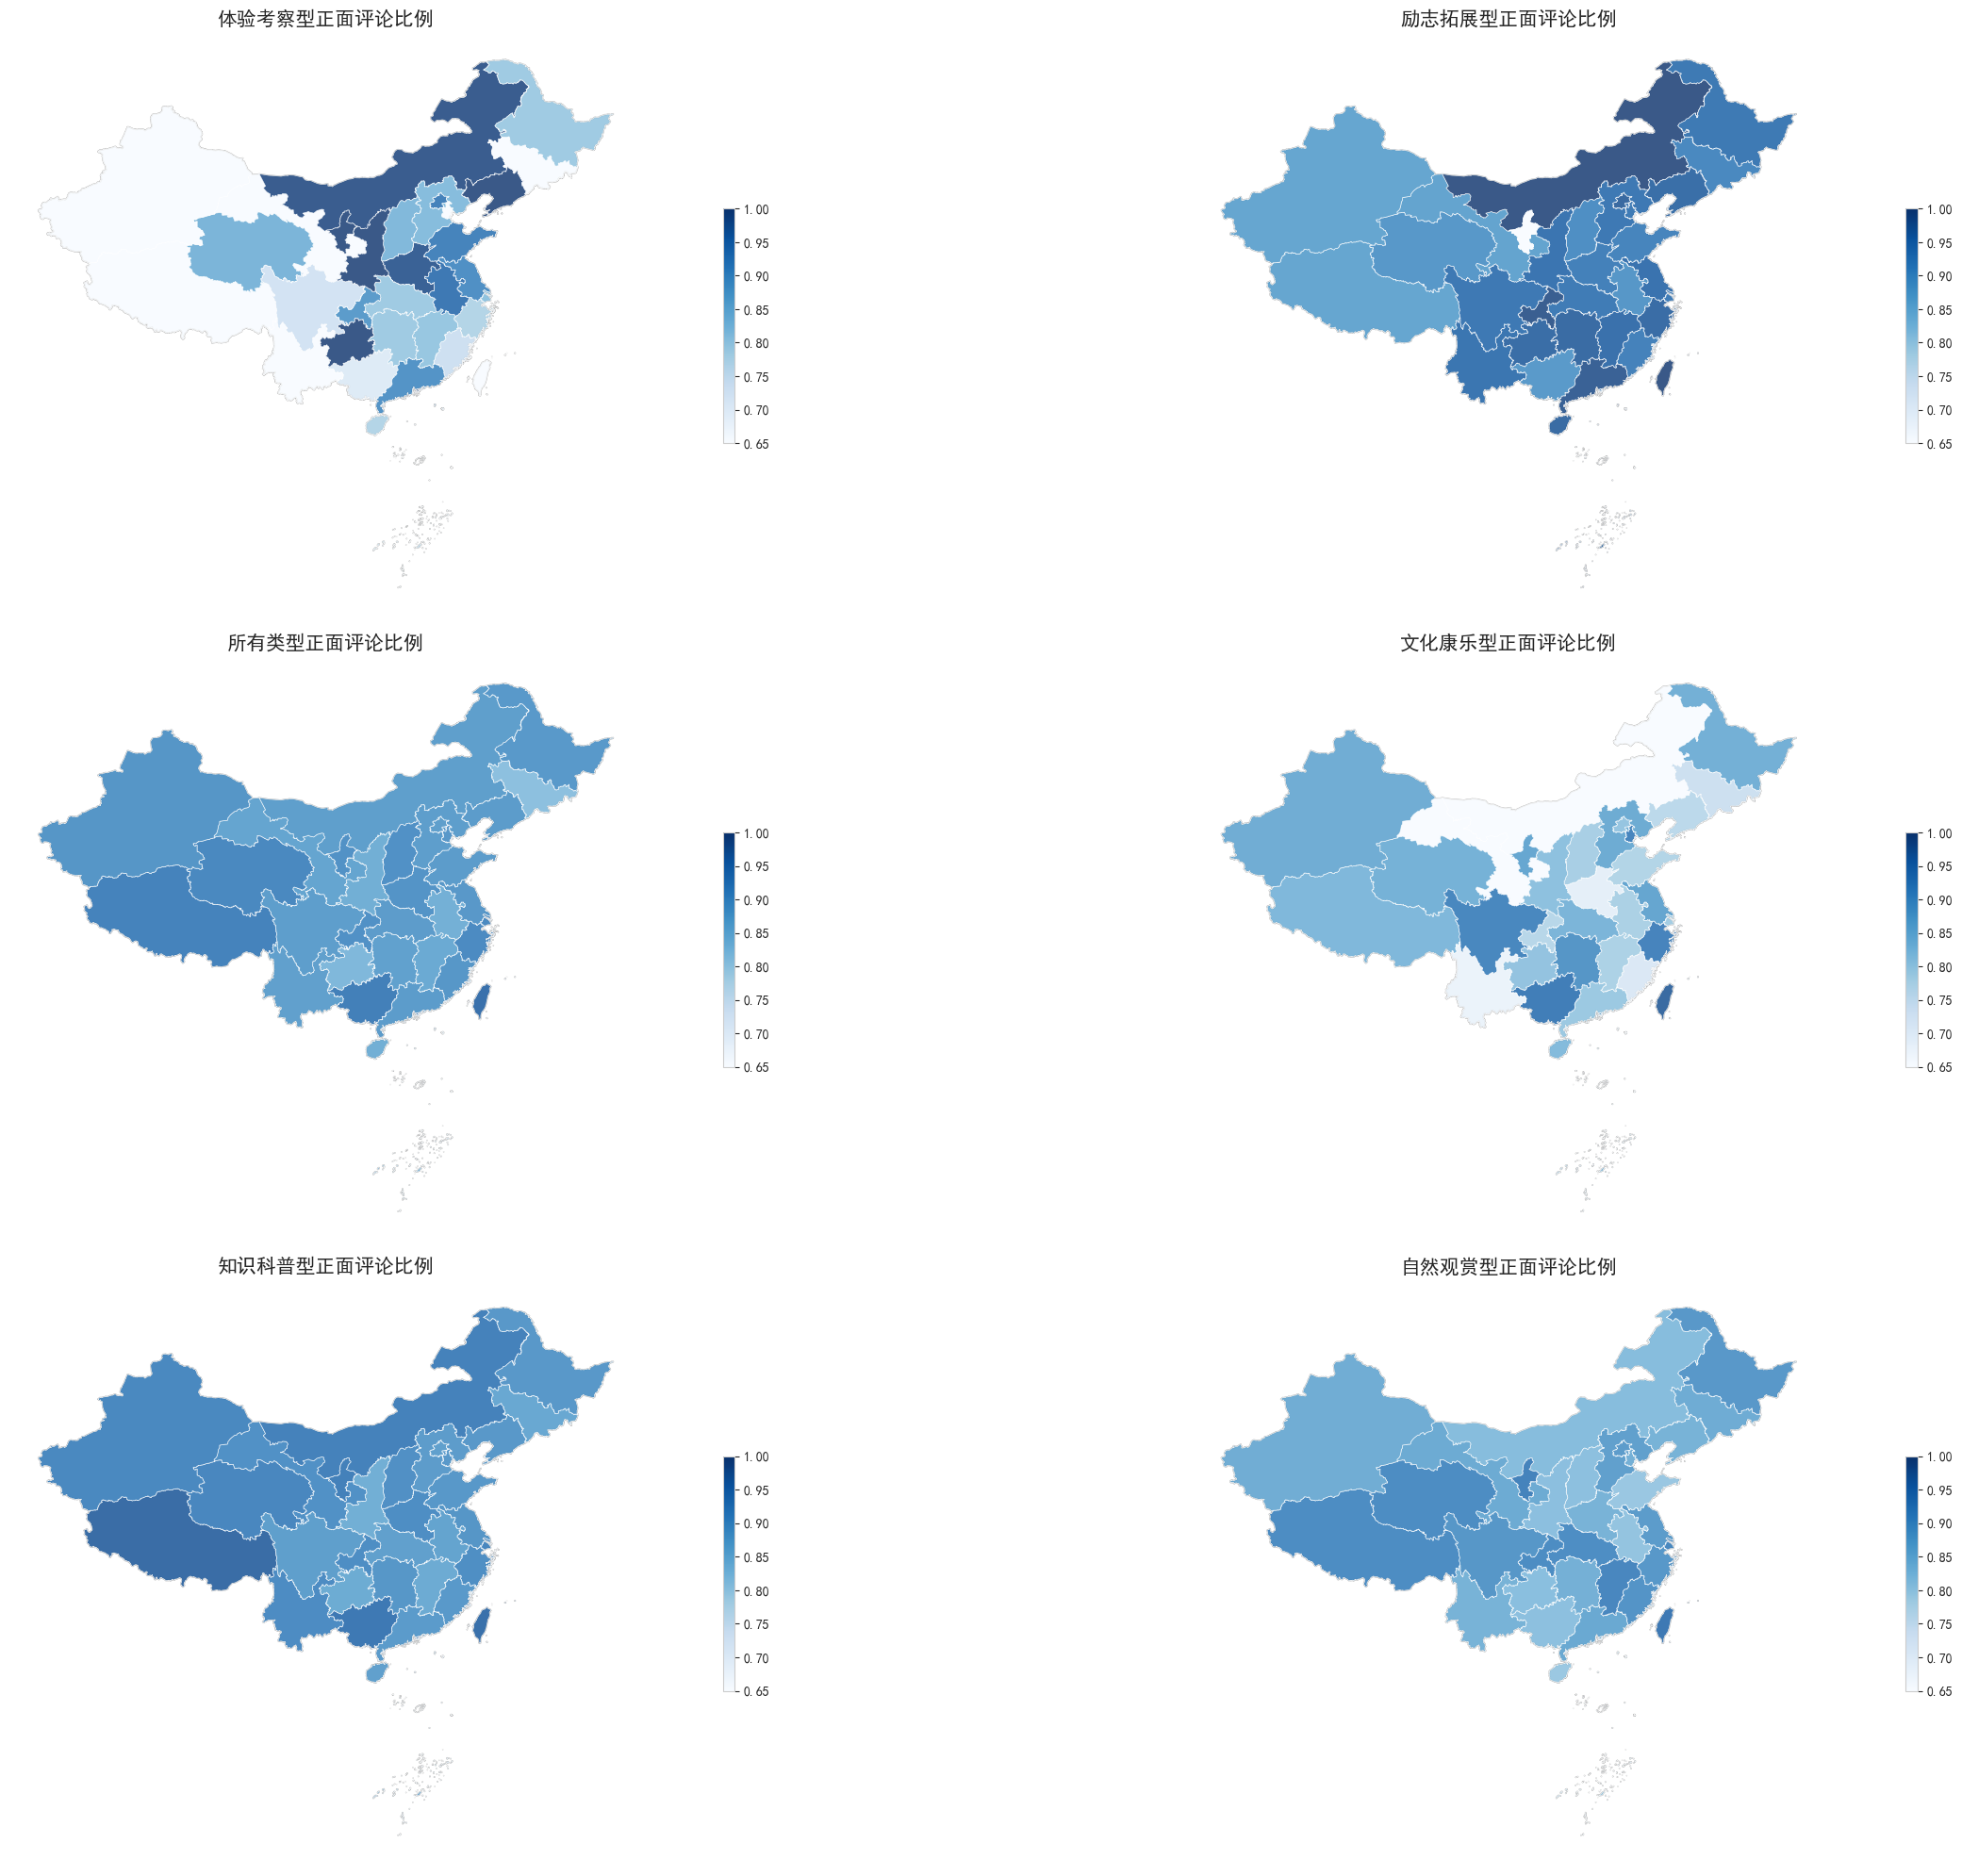

In [33]:
# 获取所有POI类型的好评率列名
rating_columns = [col for col in merged_data.columns if '正面评论比例_' in col]
vmin = 0.65
vmax = merged_data[rating_columns].max().max()
print(f'统一色域范围: {vmin:.3f} ~ {vmax:.3f}')
# 创建2行3列的子图
fig, axes = plt.subplots(3, 2, figsize=(30, 20))

# 设置统一的配色方案（可以使用不同的配色）
# cmaps = ['Blues', 'PuBu', 'GnBu', 'BuPu', 'YlGnBu','Blues']  # 五种不同的配色
cmaps = ['Blues'] * 6
# 绘制中国整体轮廓作为背景（用于每个子图）
china_outline = merged_data.dissolve()

# 遍历5个POI类型
for i in range(6):
    row = i // 2  # 计算行号：0,0,0,1,1
    col = i % 2   # 计算列号：0,1,2,0,1
    
    poi_type = rating_columns[i].replace('正面评论比例_', '')
    
    # 绘制中国轮廓
    china_outline.plot(ax=axes[row, col], color='none', edgecolor='grey', linewidth=1, alpha=0.6)
    
    ### !!!!还需要统一图例的值域
    # 绘制数据
    merged_data.plot(column=rating_columns[i], 
                     cmap=cmaps[i],
                     ax=axes[row, col],
                     legend=True,
                     legend_kwds={
                         'shrink': 0.4,
                         'location': 'right',
                         'aspect': 20,    # 去除图例框，这个参数就够了
                     },
                     edgecolor='white',
                     vmin=vmin,   # 🔹统一下界
                     vmax=vmax,   
                     alpha=0.8,
                     linewidth=0.5)
    
    axes[row, col].set_title(f'{poi_type}正面评论比例', fontsize=15, fontweight='bold')
    axes[row, col].set_axis_off()


plt.tight_layout()
plt.show()